<a href="https://colab.research.google.com/github/csaundersshultz/HotLINK/blob/main/HotLINK_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **HotLINK Tutorial**
This notebook is intended to serve as a tutorial for the Hotspot Learning and Identification Network (HotLINK). For this tutorial we use VIIRS (SNPP) data at Shishaldin Volcano for the month of July 2019, with eruption onset 2019-07-12. Code cells below perform the following actions, in order:

1. Install hotlink via github
2. Load and visualize one image from the example dataset
3. Import functions to normalize and crop the example image
4. Load the model and make a prediction for a single image
5. Calculate radiative power and brightness temperatue for that image, and visualize the detected pixels
6. Then load all the example images, apply the model to all of the images, and then visualize as a time series of detections.

## Downloading data:
Note, this tutorial does not go through the data download process, but starts with already cropped level 1b VIIRS data. To download your own data of interest, whether VIIRS or MODIS, you can follow the steps on the NASA Earthdata website [Link], and process the files using the crop_to_tiff function of the hotlink package.

# 1. Install hotlink



In [1]:
#install the hotlink package from github
!pip install --quiet git+https://github.com/csaundersshultz/HotLINK

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.6 MB/s eta 0:00:00


# 2. Load example image

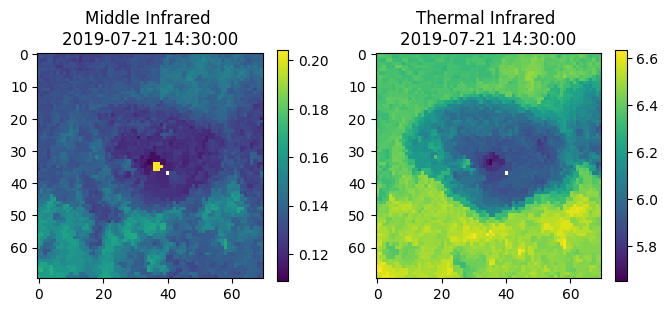

In [10]:
#visualize an image from the example dataset
from hotlink import load_example_data
import matplotlib.pyplot as plt
import numpy as np

mir, tir, d8 = load_example_data(170) #load image 160/256

fig,axs = plt.subplots(figsize=(8,4), ncols=2)
im0 = axs[0].imshow(mir)
plt.colorbar(im0, ax=axs[0], shrink=0.75)
t = axs[0].set_title(f"Middle Infrared \n{d8}")
im1 = axs[1].imshow(tir)
plt.colorbar(im1, ax=axs[1], shrink=0.75)
t = axs[1].set_title(f"Thermal Infrared \n{d8}")

As you can see, the data is not normalized. It is also 70x70, and the model requires images of size of 64x64. Next we will load some support functions to normalize and crop the data.
# 3. Pre-processing

In [11]:
from hotlink.support_functions import crop_center, normalize_MIR, normalize_TIR

n_mir = normalize_MIR(mir) #note, normalize also fills in missing pixels
n_tir = normalize_TIR(tir)
stacked = np.dstack([n_mir, n_tir])
print(f"The stacked image shape is {stacked.shape}")
cropped = crop_center(stacked)
print(f"After cropping the image shape is {cropped.shape}")

The stacked image shape is (70, 70, 2)
After cropping the image shape is (64, 64, 2)


# 4. Predicting a single image
Now that we have prepared this image, we can load the hotlink model and then use it to detect hotspot pixels within the image. Notice that the input to the model is a numpy array with shape [1, 64, 64,2], this corresponds to 1 image, height and width of 64, and 2 bands (MIR first and then TIR). The model can also be used to predict multiple images at once, which we will use later.

The output size is [1, 24, 24, 3]. The prediction is made for a central region in the input image, and contains probabilities for three classes in the final dimension --> (0=background, 1=hotspot adjacent, 2=hotspot).


In [12]:
from hotlink import load_hotlink_model
from hotlink.support_functions import radiative_power, brightness_temperature#, plot_detection
from skimage.filters import apply_hysteresis_threshold

model = load_hotlink_model() #load the model

input = cropped.reshape(1,64,64,2)

# make probabilistic prediction
prediction = model.predict(input) #shape=[batch_size, 24, 24, 3], for 3 predicted classes:background, hotspot-adjacent, and hotspot

# get predicted class for each pixel (highest probability)
pred = np.array(np.argmax(prediction[0,:,:,:], axis=2)) #classes 0,1,2 correspond to bg, hot-adjacent, and hot

# use hysteresis thresholding to generate a binary map of hotspot pixels
prob_active = prediction[0,:,:,2] #map with probabilities of active class
max_prob_active = np.max(prob_active) #highest probability per image, equated to probability that the image contains a hotspot
active_map = apply_hysteresis_threshold(prob_active, low=0.4, high=0.5).astype('int') #hysteresis thresholding active mask

#now visualize some of the layers:
fig, axs = plt.subplots(ncols=3, figsize=(12,4))
im0 = axs[0].imshow(prob_active)
plt.colorbar(im0, ax=axs[0])
axs[0].set_title("Hotspot probabilities")

im1 = axs[1].imshow(pred)
plt.colorbar(im1, ax=axs[1])
axs[1].set_title("Predicted class for each pixel")

im2 = axs[2].imshow(active_map)
plt.colorbar(im2, ax=axs[2])
axs[2].set_title("Hotspot pixels, Hysteresis Thresholded")


OSError: ignored

# Calculating metrics and displaying hotspot detection

In [ ]:
# generate results:
mir_analysis = crop_center(mir, size=24) #crop to output size, for analysis
rp = radiative_power(mir_analysis, active_map, cellsize=371, rp_constant=17.34)

#get just hotspot pixels
hotspot = mir_analysis[ np.where(active_map==1) ]
hotspot_bt = brightness_temperature(hotspot, wl=3.74e-6)
#we can also get brightness temperature of the background area in this way etc.

#finally, plot the detection with some information about it:
#plot_detection(mir_analysis, active_map, )